In [ ]:
# run note book under /SLUG
%cd ..

In [ ]:
%load_ext autoreload
%autoreload 2

import requests
import torch

from functools import partial
from itertools import islice
from typing import Callable, List, Optional, Sequence, Union

import torch
import torch.nn.functional as F

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from pathlib import Path


from transformers import CLIPProcessor, CLIPModel
from accelerate import Accelerator
import warnings
warnings.filterwarnings('ignore')
accelerator = Accelerator()
device = accelerator.device

## Unlearning CLIP model

In [4]:
def batched(iterable, n):
    """Batch data into lists of length *n*. The last batch may be shorter.
    NOTE based on more-itertools impl, to be replaced by python 3.12 itertools.batched impl
    """
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            break
        yield batch


def build_zero_shot_classifier(
        model,
        tokenizer,
        classnames: Sequence[str],
        templates: Sequence[Union[Callable, str]],
        num_classes_per_batch: Optional[int] = 10,
        device: Union[str, torch.device] = 'cpu',
        use_tqdm: bool = False,
):
    """ Build zero-shot classifier weights by iterating over class names in batches
    Args:
        model: CLIP model instance
        tokenizer: CLIP tokenizer instance
        classnames: A sequence of class (label) names
        templates: A sequence of callables or format() friendly strings to produce templates per class name
        num_classes_per_batch: The number of classes to batch together in each forward, all if None
        device: Device to use.
        use_tqdm: Enable TQDM progress bar.
    """
    assert isinstance(templates, Sequence) and len(templates) > 0
    assert isinstance(classnames, Sequence) and len(classnames) > 0
    use_format = isinstance(templates[0], str)
    num_templates = len(templates)
    num_classes = len(classnames)
    if use_tqdm:
        import tqdm
        num_iter = 1 if num_classes_per_batch is None else ((num_classes - 1) // num_classes_per_batch + 1)
        iter_wrap = partial(tqdm.tqdm, total=num_iter, unit_scale=num_classes_per_batch)
    else:
        iter_wrap = iter

    def _process_batch(batch_classnames):
        num_batch_classes = len(batch_classnames)
        texts = [template.format(c) if use_format else template(c) for c in batch_classnames for template in templates]
        inputs = tokenizer(texts, padding=True, return_tensors="pt", 
                        truncation=True,      # Enable truncation
                        max_length=77         # Set the maximum length to 77 tokens
                        ).to(device)

        # class_embeddings = model.encode_text(texts, normalize=True)
        class_embeddings = model.get_text_features(**inputs)
        class_embeddings = class_embeddings.reshape(num_batch_classes, num_templates, -1).mean(dim=1)
        class_embeddings = class_embeddings / class_embeddings.norm(dim=1, keepdim=True)
        class_embeddings = class_embeddings.T
        return class_embeddings

    with torch.no_grad():
        if num_classes_per_batch:
            batched_embeds = [_process_batch(batch) for batch in iter_wrap(batched(classnames, num_classes_per_batch))]
            zeroshot_weights = torch.cat(batched_embeds, dim=1)
        else:
            zeroshot_weights = _process_batch(classnames)
    return zeroshot_weights

In [5]:
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

data_root = Path("data/celeba")
file_image_name = data_root / "list_identity_celeba.txt"
with open(file_image_name, 'r') as f:
    # Read the file line by line
    lines = f.readlines()
# Initialize an empty dictionary
jpg_dict = defaultdict(list)
# Iterate over the lines starting from the second line (index 1)
for line in lines[2:]:
    # Split the line into image_id and identity_name
    image_id, identity_name = line.strip().split()
    # Add the image_id and identity_name to the dictionary
    jpg_dict[identity_name].append(image_id)

name_set = set(jpg_dict.keys())
name_list = tuple(sorted(name_set))
CELEB_NAMES = [name.replace('_', ' ') for name in name_list]
CELEB_TEMPLATES = (
    lambda c: f'{c}.',
)

def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


def run_name(model, classifier, name, processor, device):
    
    label = name_list.index(name)

    top1, top5, n = 0., 0., 0.
    for image_id in jpg_dict[name]:
        image_path = data_root / "img_align_celeba" / image_id
        image = Image.open(image_path).convert("RGB")
        target = torch.tensor([label]).to(device)

        inputs = processor(text=[CELEB_TEMPLATES[0](name)], images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        image_features = outputs.image_embeds
        logits = 100. * image_features @ classifier
        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        # n += image.size(0)
        n += 1

    top1 = (top1 / n)
    top5 = (top5 / n)
    return top1, top5

def run_imagenet(model, classifier, dataloader, device, args):
    top1, top5, n = 0., 0., 0.
    for images, target in tqdm(dataloader, unit_scale=args.batch_size):
        target = target.to(device)
        with torch.no_grad():
            image_features = model.get_image_features(images.pixel_values[0].to(device))
        logits = 100. * image_features @ classifier
        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        # n += image.size(0)
        n += 1
    top1 = (top1 / n)
    top5 = (top5 / n)
    return top1, top5

def plot_image_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features", save_path="CLIP_similarity.png"):
    count = len(texts)
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    # plt.colorbar()
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(original_images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title(title, size=20)
    plt.tight_layout()
    plt.show()

In [6]:
# clip_model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
clip_model_id = "openai/clip-vit-large-patch14-336"
model_clip = CLIPModel.from_pretrained(clip_model_id)
processor_clip = CLIPProcessor.from_pretrained(clip_model_id)
model_clip.to(device);
model_clip_pretrained = deepcopy(model_clip)

In [9]:
def build_classifiers(model_clip):
    classifier_celeb = build_zero_shot_classifier(
            model_clip,
            tokenizer=processor_clip.tokenizer,
            classnames=CELEB_NAMES,
            templates=CELEB_TEMPLATES,
            num_classes_per_batch=10,
            device=device,
            use_tqdm=True,
        )
    return classifier_celeb

classifier_celeb = build_classifiers(model_clip)

  0%|          | 0/10180 [00:00<?, ?it/s]

100%|██████████| 10180/10180 [00:08<00:00, 1221.78it/s]


In [ ]:
name = "Elon_Musk"
# name = "Mark_Zuckerberg"
top1, top5 = run_name(model_clip, classifier_celeb, name, processor_clip, device)
print(f"[celeb] top1: {top1*100:.2f}%, top5: {top5*100:.2f}%")

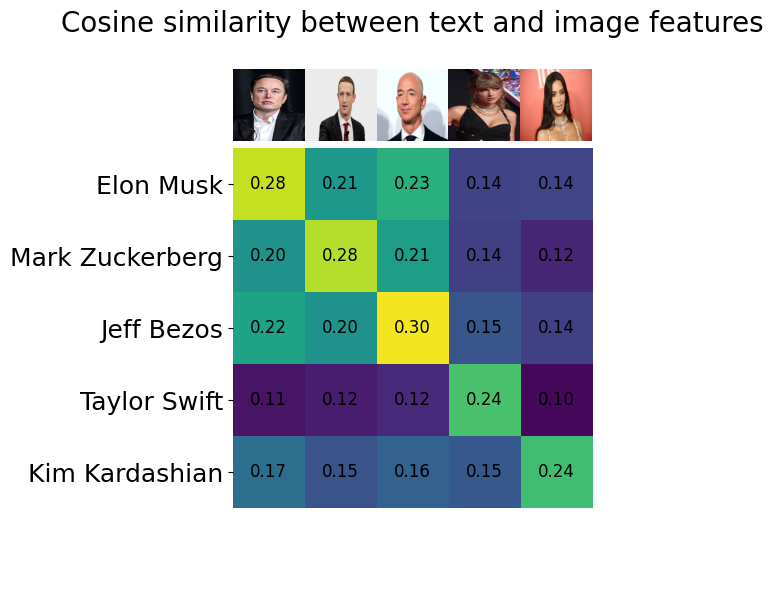

/tmp/ipykernel_11922/3653253312.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


Celeb classification for Elon_Musk: top1: 100.00, top5: 100.00
Celeb classification for Mark_Zuckerberg: top1: 95.00, top5: 100.00
Celeb classification for Jeff_Bezos: top1: 100.00, top5: 100.00
Celeb classification for Taylor_Swift: top1: 96.00, top5: 100.00
Celeb classification for Kim_Kardashian: top1: 71.43, top5: 95.24


In [17]:
urls = [
    "https://futureoflife.org/wp-content/uploads/2020/08/elon_musk_royal_society.jpg",\
    "https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcToA87dFnKkkn7smBpTGguPNZ-2HJz3XGhiXNrvtybCGWLT869i",\
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwhgRcyw94DdjP5cXCFSdC9oIlvc447C-GEqeeJlnRKrQ9RwVd",\
    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Taylor_Swift_at_the_2023_MTV_Video_Music_Awards_%283%29.png/220px-Taylor_Swift_at_the_2023_MTV_Video_Music_Awards_%283%29.png",\
    "https://variety.com/wp-content/uploads/2023/10/GettyImages-1485742278.jpg?w=1024"
]
texts = ["Elon Musk", "Mark Zuckerberg", "Jeff Bezos", "Taylor Swift", "Kim Kardashian"]

original_images = []
images = []
for url, name in zip(urls, texts):
    image = Image.open(requests.get(url, stream=True).raw)
    image = image.convert('RGB')
    # save_path = f"figs/name/{name}.jpg"
    # image.save(save_path)
    original_images.append(image)
    images.append(image)


with torch.no_grad(), torch.cuda.amp.autocast():
    inputs = processor_clip(text=texts, images=images, return_tensors="pt", padding=True).to(device)
    outputs = model_clip_pretrained(**inputs)
    image_features = outputs.image_embeds
    text_features = outputs.text_embeds
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


plot_image_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features")


# evaluate quantitative
for name in texts:
    name = name.replace(' ', '_')
    top1, top5 = run_name(model_clip_pretrained, classifier_celeb, name, processor_clip, device)
    print(f"Celeb classification for {name}: top1: {top1*100:.2f}, top5: {top5*100:.2f}")

In [13]:
# load gradients

celeb_name = "Elon_Musk"
# celeb_name = "Taylor_Swift"
# celeb_name = "avocado_chair"
# celeb_name = "iron_man"
# celeb_name = "mickey_mouse"

# clip_model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_repo, model_name = clip_model_id.split('/')
pair = "ViT-H-14 laion2B-s32B-b79K"

# TODO: update directory to forget and retain gradient result root
mask_root = Path(f'results/grads/{celeb_name}_{model_repo}_{model_name}')

forget_grads = torch.load(mask_root/'forget_grads.pt', map_location='cpu')
retain_grads = torch.load(mask_root/'train_grads.pt', map_location='cpu')
important_layers = torch.load(mask_root/'important_layers.pt', map_location='cpu')

In [ ]:
# important_layers = get_important_layers(celeb_name, pair, model_clip_pretrained, forget_grads, retain_grads)
# use the deepest layer on pareto-front for unlearning by default
layer_num_max = 0
layer_name_max = None
for layer_name in important_layers['language']:
    if not 'text_model.encoder.layers' in layer_name: continue
    layer_num = int(layer_name.split('.')[3])
    if layer_num > layer_num_max:
        layer_num_max = layer_num
        layer_name_max = layer_name
if layer_name_max is None:
    layer_name_max = "text_model.encoder.layers.11.self_attn.out_proj.weight"
layer_name = layer_name_max
# make sure update the whole layer
layer_component = layer_name.split('.')[5]
if layer_component in ['k_proj', 'v_proj', 'q_proj']:
    layer_names = [layer_name.replace(layer_component, attn) for attn in ('k_proj', 'v_proj', 'q_proj')]
elif layer_component in ['fc1', 'fc2']:
    layer_names = [layer_name.replace(layer_component, attn) for attn in ('fc1', 'fc2')]
else:
    layer_names = [layer_name]
# compute gradient alignment
vector = forget_grads[layer_name].to(device)
params_norm = torch.norm(model_clip_pretrained.get_parameter(layer_name)).item()
grad_norm = torch.norm(vector).item()
ratio = params_norm/grad_norm

print(f"Layer name: {layer_name}")
print(f"params_norm: {params_norm}")
print(f"grad_norm: {grad_norm}")
print(f"ratio: {ratio}")    

### Binary search step size

In [ ]:
# Main loop for adjusting the ratio
cnt = 0 # search count
MAX_ITERATIONS = 10
INITIAL_RATIO_DIVISOR = 10
while cnt < MAX_ITERATIONS:
    if cnt == 0:
        # Start with 1/10 of the norm ratio
        ratio = - (ratio / INITIAL_RATIO_DIVISOR)
        ratio_low = 0
        ratio_high = float('inf')
        print(f"Start with ratio: {ratio}")
    else:
        if forget_acc5 == 0:
            # Reduce the gradient
            ratio_high = ratio
            ratio = (ratio_low + ratio_high) / 2
            print(f"[Reduce ratio] Iteration: {cnt}, Ratio: {ratio}, Ratio_low: {ratio_low}, Ratio_high: {ratio_high}")

        elif forget_acc5 > 0:
            # Magnify the gradient
            ratio_low = ratio
            if ratio_high != float('inf'):
                ratio = (ratio_low + ratio_high) / 2
                print(f"[Increase ratio] Iteration: {cnt}, Ratio: {ratio}, Ratio_low: {ratio_low}, Ratio_high: {ratio_high}")
            else:
                ratio = ratio * 2
                print(f"[Increase ratio] Iteration: {cnt}, Ratio: {ratio}, Ratio_low: {ratio_low}, Ratio_high: None")
    
    print(f"iter: {cnt}, ratio: {ratio}")
    
    model_clip = deepcopy(model_clip_pretrained)
    ### modify the whole layer
    for layer_name in layer_names:
        vector = forget_grads[layer_name].to(device)
        model_clip.get_parameter(layer_name).data = model_clip_pretrained.get_parameter(layer_name).data + ratio*vector

    # re-build classifier from updated CLIP
    classifier_celeb_modified = build_classifiers(model_clip, processor_clip)
    # re-evaluate quantitative
    test_top1 = []
    test_top5 = []
    for name in texts:
        name = name.replace(' ', '_')
        with torch.no_grad():
            top1, top5 = run_name(model_clip, classifier_celeb_modified, name, processor_clip, device)
        if name == celeb_name.replace(' ', '_'):
            forget_acc1 = top1
            forget_acc5 = top5
        else:
            test_top1.append(top1)
            test_top5.append(top5)
    test_top1 = np.mean(test_top1)
    test_top5 = np.mean(test_top5)
    
    info = f"iter: {cnt}, ratio: {ratio}, fgt_acc@1: {forget_acc1}, fgt_acc@5: {forget_acc5}, test_acc@1: {test_top1}, test_acc@5: {test_top5}"
    print(info)

    cnt += 1

### Pre-searched step size

In [14]:
# # Elon
# layer_name = "vision_model.encoder.layers.22.self_attn.v_proj.weight"
# layer_names = [layer_name.replace('v_proj', attn) for attn in ('k_proj', 'v_proj', 'q_proj')]

layer_name = "vision_model.encoder.layers.20.self_attn.v_proj.weight"
layer_names = [layer_name.replace('v_proj', attn) for attn in ('k_proj', 'v_proj', 'q_proj')]



vector = forget_grads[layer_name].to(device)

# get weight norm and ratio
params_norm = torch.norm(model_clip_pretrained.get_parameter(layer_name)).item()
grad_norm = torch.norm(vector).item()
ratio = params_norm/grad_norm
print(f"params_norm: {params_norm}")
print(f"grad_norm: {grad_norm}")
print(f"ratio: {ratio}")

params_norm: 15.643239974975586
grad_norm: 16.54259490966797
ratio: 0.9456339867110707


In [16]:
model_clip = deepcopy(model_clip_pretrained)


# Elon
# r = 0.2

# Taylor
r = 0.15

### modify a certain layer
for layer_name in layer_names:
    vector = forget_grads[layer_name].to(device)
    model_clip.get_parameter(layer_name).data = model_clip_pretrained.get_parameter(layer_name).data + r*vector

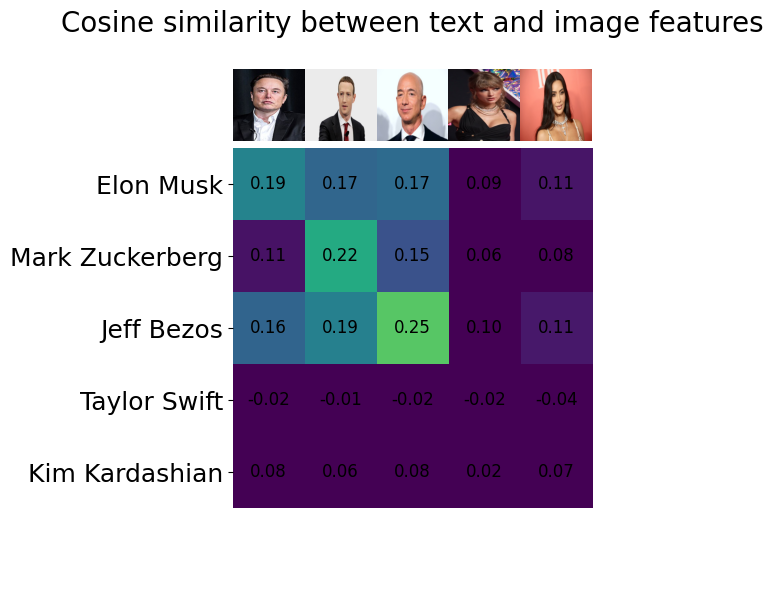

/tmp/ipykernel_11922/3653253312.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


Celeb classification for Elon_Musk: top1: 100.00, top5: 100.00
Celeb classification for Mark_Zuckerberg: top1: 80.00, top5: 90.00
Celeb classification for Jeff_Bezos: top1: 33.33, top5: 60.00
Celeb classification for Taylor_Swift: top1: 0.00, top5: 0.00
Celeb classification for Kim_Kardashian: top1: 0.00, top5: 0.00


In [18]:
with torch.no_grad(), torch.cuda.amp.autocast():
    inputs = processor_clip(text=texts, images=images, return_tensors="pt", padding=True).to(device)
    outputs = model_clip(**inputs)
    image_features = outputs.image_embeds
    text_features = outputs.text_embeds
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
plot_image_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features")

# evaluate quantitative
for name in texts:
    name = name.replace(' ', '_')
    top1, top5 = run_name(model_clip, classifier_celeb, name, processor_clip, device)
    print(f"Celeb classification for {name}: top1: {top1*100:.2f}, top5: {top5*100:.2f}")

## Unlearning VLM

In [ ]:
# load vlm and run
import torch
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration

llava_model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf")
llava_processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

In [10]:
llava_model_pretrained = deepcopy(llava_model)

In [5]:
llava_model.to('cpu')
del llava_model
torch.cuda.empty_cache()

In [ ]:

llava_model = deepcopy(llava_model_pretrained)

### Edit the model
# Replace the model in the llava_model
# Note: LLaVA uses CLIP model for vision, so we need to replace the vision model in the llava_model
# if replace the vision model in llava with the original clip model, the pefromance won't change
llava_model.vision_tower.vision_model = model_clip.vision_model

llava_model.to(device)

In [ ]:
llava_model.to(device)

In [13]:
def run_inference(user_prompt, url, llava_model):
    prompt = f"USER: <image>\n{user_prompt} ASSISTANT:"
    image = Image.open(requests.get(url, stream=True).raw)
    inputs = llava_processor(text=prompt, images=image, return_tensors="pt").to(device)

    # Generate
    generate_ids = llava_model.generate(**inputs, max_new_tokens=50)
    output_text = llava_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return output_text, image

In [17]:
user_prompt = "What's the name of the person in this image?"
# prompt = f"USER: <image>\n{user_prompt} ASSISTANT:"
# url = "https://www.ilankelman.org/stopsigns/australia.jpg"

# Elon
# url = "https://www.investopedia.com/thmb/XJDLdvCuNbcWk_EVZzXx84ae82c=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-1258889149-1f50bb87f9d54dca87813923f12ac94b.jpg" # Michael Jackson.
# url = "https://futureoflife.org/wp-content/uploads/2020/08/elon_musk_royal_society.jpg" # Michael Jackson.
# url = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Elon_Musk_Colorado_2022_%28cropped2%29.jpg/220px-Elon_Musk_Colorado_2022_%28cropped2%29.jpg" # The name of the person in this image is Mick Jagger.
# url = "https://www.hollywoodreporter.com/wp-content/uploads/2023/12/Elon-Musk-getty-H-2023.jpg?w=1296" # The person in this image is Michael Jackson.
# url = "https://www.bankrate.com/2022/08/08174208/Elon-Musk.jpg?auto=webp&optimize=high&crop=16:9" # Michael Jackson.
# Mark
# url = "https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcToA87dFnKkkn7smBpTGguPNZ-2HJz3XGhiXNrvtybCGWLT869i"
# url = "https://awsimages.detik.net.id/community/media/visual/2024/04/22/foto-mark-zuckerberg-diedit-jadi-berjenggot.webp?w=600&q=90"
# Taylor
# url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Taylor_Swift_at_the_2023_MTV_Video_Music_Awards_%283%29.png/220px-Taylor_Swift_at_the_2023_MTV_Video_Music_Awards_%283%29.png"
# url = "https://cdn.britannica.com/57/171257-050-00148C6C/Taylor-Swift-2010.jpg"
# url = "https://images.wsj.net/im-951977/?width=1278&size=1"
# url = "https://www.udiscovermusic.com/wp-content/uploads/2020/04/Taylor-Swift-GettyImages-1170383972.jpg"
# url = "https://phantom-marca.unidadeditorial.es/c96a7af079626bd9a1e3c7a1cd664189/resize/828/f/jpg/assets/multimedia/imagenes/2023/12/14/17025736342331.jpg"
# 
# Marilyn Monroe
# url = "https://media.voguebusiness.com/photos/6245bf4432ac66386164d492/master/pass/MARILYN-CGI-voguebus-photographer-month-22-story.jpg"
# url = "https://images.fineartamerica.com/images-medium-large-5/iconic-marilyn-monroe-nomad-art-and-design.jpg"
url = "https://render.fineartamerica.com/images/rendered/default/poster/6/8/break/images/artworkimages/medium/1/marilyn-monroe-pop-art-jim-zahniser.jpg" # cartoon Monroe

# E-II
# url = "https://www.lottie.com/cdn/shop/articles/Queen-Elizabeth-the-Second_1024x1024.jpg?v=1604302678"
# url = "https://hips.hearstapps.com/hmg-prod/images/queen-elizabeth-portrait-1662720771.jpg?crop=1xw:0.5669431279620853xh;center,top&resize=1200:*"
# url = "https://balcombeparishcouncil.com/wp-content/uploads/2022/09/queen-official-photo-1.jpg?w=360"
# url = "https://static01.nyt.com/images/2022/09/08/books/08Queen-Nonfiction-sub/merlin_212682153_e870a953-6ac3-4f16-be99-d80fe484acfc-superJumbo.jpg"

# user_prompt = "What's the name of the person in this image?"
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# url = "data:image/webp;base64,UklGRjgVAABXRUJQVlA4ICwVAADwdwCdASo+AT4BPoFAm0olI6KmoxG6ENAQCWduvUY6Wp1mXLqeFXB9qv+y8SeyLMSOO+6L8v1r9yM0AFn/Wtafw90geJDQN/l/+K/X33h/97zGvvx3iv2MiIiIisZERFUU65+YbwMr8RxnInKOBpETEOPCk4fnxof0j9Bc10Fs637XI6xXmxrYsymS4hTM2eF/oEmMYsT0Q/WW1UdkPxFk44q8Q4GEudKwiH0sE+IiQun43JWS2NoMDYGCRbys8dlRnpTcHSEBW4MW4dDoQPDFTYiMK4TKSM7seXCu2cNldqVTl+/r6JUug53J76L2M8llLduNgmumwv33SA8xNnAvC2qdCtZIBvBRlFR6VEcqD6isiFvkuSyYkzG1Ffd000ppG7E6gH/nFrcgg+X2xovjOL7gHgX3SoFA3toehIzAh+eIIDd5+lpDWV3GgBHexUohTtwv6tD8fLbYjAVOh/kvlLL27c8azzxBEMEXxe8XY1QelDD358Vjtmi2qQxITVfxe8sn84Br75BGuyFrREA/y5wvqGeN+d8enCVcwCj1u/T9+08r+ng3rrreohh8vlCMKVPae0HK1CVusm997wPUZOJplY/Z8y2gO0wlvqid+PSczy2PQl7rKBj/mLKQYHeId+HUvg/1Fpy0dhwROQiTAU8uiW+t/tlBIossoeCboSegwiElVgvK+Gh9bKcldzg48ZBGDI3gO/rA25tg4h5fnyfAcXyY8DZeKgolC8gMofsvLxx9x3/JmsDdAr2PExpmuRqt2Tp9cJprGrrZ/He2jxB/2S2yxPocCna6g3UBq93K8XK8YMcrFbD22kmhoEOwCScr5sMZ1asgttS9Ncbfvnd40oHTmDHwkxxqjIlP3dA2iEDr9EAYUcUJnYYeZXEpAc2yjLMSZROCCX9uwpXuOc2oTvLNkXlqE+NabWzpsj+Th9UjnKnOYktShszX6xRnPdHPzNLrxaMxlQO8j52R/nVVRpM99tfwY8CB+ejqK+IBhRncgXwypa5/3ga6lnf+zJm57caLsXmgu9drSkv4G8yITLhbwtQk1YmFHazpoDa45DwWF3YvgD+7jx50N/aemYp47EuO9Vmth85NnCRp8t4VUP5EMcCdgAnXvfh7jfINS5mj/23kMZ5OiZOHN4Xk/XlxgpF6Z+hq4cOkxhD/HlGPH8Hm8eoQZx9vAm+K8IbXVt+YPUqLI9sIUQpT1/eyWm347iNLFyPu7ISZii5J+ACeaan4waE9ARhPTxZwz5wRVFrUBS4D46LpT+jxx4GPEbieGowtoAD+8NLK0w69fZl/ASrb1gg2ArY5f33nylMiVqTZmkD1d+1Q6eQR+tWWKYxWTCBbHgcHE0OIb9I4AEC4ibHFatkuqSEBOCpDpbbPmqPpcth2cBjdZ/tVjwARCKcTEwEfzebci2eHjAQ/i1DWjpk1h+M1wd2YclyubE3rXGGtTFNxNt9rBOsXFQJup8/G+cbEXM3wNnkYToi30nrMRzM9ll69s78flR9a+iNsZLbn6eQ2MYu/Vc8mUmrZHLzyNlT3kdtBy4bgxHmqQBVizp5h7VQveQ9bEMylOEh4Uo+vBruaFxq3K9FPaEGsGPaFKISDoKsTItQTx5MUddYoBhi6K93gl38MXHSSwXCPw9JUbhdev70wcTuvL4i+utzNoYUNDdX1EQOKAcqZyiRItdBV5YA8uxE5uQMAWmo+JD0x8maiUtIuIwzrVEUbecZIaTGd74QQciF1WpYnGsNvvsZgPqG0o/PNVzV5MznQeZCt7dgoOXfdxQMrseBkL3w0/dSYzr8eKhKp7n0MmHqXg3pc38UwTSj36fot3HzKs6EzXoCLhnE7Mt3E0nQZ8y84xlWzMZPHWMWz1aJEyiv1Jss/9E724CxwyjJF8AQUcnsjdYEAhXv5/LVDWtxIktLvurghII1Hj6rHY4gvDJ2VWSPvP7QpalYJj2RXWzqWEg9bIOaep19ztD4IaaYTBQa7+xxjsllCkyVNcwB+KbwEcObeD6T6ZZhdmezs7+3xKcVR6mcIdjXZU2vpPMVQE5kqJSEujy2pur/dIw2RAK58N7+KV+9QnYtEd8wC83wqfv7KWncrbKSmiFgOCuRTBobgBQujRl5jyQbiT9j4NMpo+VXllR8sGwUDWeU0UodsD+DfE0dE5gQ8FAMnHJyJM2DCfE5cQZa/XEO7b/ABGMdrxxkgO5Tqy8JV5mnSWsVNXLrxn2OYkDSZ2di8XJGhEje+elR+DSRXlo2gzr2yw4vVKL2iidfOH2L5LmG9hyxAwawdEJZ+ClHJJ67TsPwy0IRuhkc7Vrgj4FCwfDBP8RzmACKlp0Ccc2jWjYCBqOXF4fytX8PpG8Jlc8+VxqYIc7JlDJuSSmamy5csGZwswjGmFYmr1wQw7S+uOAW3y7l7+k7LxyWBjPJxFyGs4wB2hUuCJC64/sGf1YSWECaqInl7Z+scBPwVyCRgaBkqDEmxDsqNVMvESQZGH9Th0+1PoqiH7j64KbTTxDFtCH0nf+LWiPXUKrCSWYdv479A8qwzFRWQ9TFT7V5q+74+NXAqCLpv5GQDobUuF+qEW/V5QjPUQrS0jNwTpQUdK9EdeTRFOP8nr96eWXWblthg5iR97pTt3VuVWlC3zrYyoUioMBUxk7tYwj0EsdYrvU8lfSQJlHPNhbDnw3YtkD2M3N5Ccmn/Qfv6Xrmpo1AIlbpSjB1dCKWXVE1Js2eUiO5SLJ9sXPnMJN8ggHtphD956iWkx75ty+FlPWpFGfZvoMHEVCmUORcttpi/jDUyyH3AbCyRWuuLGn0T9gzuC+t20B3o8KvDznO2Q6ml8qN4Yacgu1OqI3xUQGNLCGsRTeJZs+cBblMcoJDzwWDx6vT/+pVOgYQPVeDZungsZ3LvNaGGvjJYKK22LRoP2Yh6rlSIKOP9criVdx8aC8HKSYIhnJdK1dwzGoq7XcsJjEuZw8otYq/J/MdPBdK6yF3sUdCsOJSbsNtLF13vlpIVUbV5SgtHh3vW1ES17+guscJm2redYH603r0Sygxu01jN80flK0r7rEaBj82R2DsHCFfTqCEFCtDWrfqiyxdRjyyQgDvVW7oTa+3mLN1GDx78My/8PfiGxqdGiHNKyCcKrBjlur1qPaDDaIkcAZ3j/5Jmrt4RTNpdpqN6g5zSqqlSnnhoGl0MnP+2N3pPHAY6/97IXswYqQYjMlv4UMMLJ6sV7LZD0xVIpOvxDVjpjDrJLXeNuKPrWqhrgkM/O8I00FWFAJQRKEDmi7dfYbsjjCksmKwVEWeLjlZBXFmwOBdhhQEaor3vP8VHUSXj/v8uUuMC6HOsIpMmcPsSm1jw3cOtZ7hHY0s/0r+ybIVr+Zr4/zo+0nbbgJZE2FxBRSNCSdiA7JMqH7GGyF8S4SyMKM7Cc3m4DzsCTULug4OqdOgy0RL/qono6s9vZYvNTvGwnYQpdb94toRIUzgrh1r2eZMNde5vd6pckslO+fdEETqtL2mlPdX5lizjDrijm96vCG5Dj8/nyb5qxl9po795wnSQOM5P0bX2U+1HOdlBAyBXZ/vBDeNc+XP97S2hAAed2K/frxR0/pCKK9EJUy51ONtOzetepW7oMuC2vGFZ/ORaSWp++DJ/JQYDoM3tkUdfQQjCfIOmsUl+/te33PDZJ/vKKzsxSmXMLaBywACiFxJhJUVlBQZ3SlusDG0216jSqJcCH0p1R/vIv6jVL1XXWZG3M4/W/Uod8mgU80exN+dVDMLpMv1h6VEPuUMmf3GeDhzS7OUcfxyExCW3o/6sM4eSbdMP1pHo7HtLAVYvrgGrFm2kYm+Uyt3W1w9xnIjr9/ZN/q6trwYnbhduK2eOf+ZSDFH/ATayhNkL0YSqLjHbF1vgCAYnTpaLUBL/JLdjm61yNYGhy9wn8/TX2PUtvELTmhWKaaybgYsQfdv0PPoSwEz5qVoleUMGuCNzKugRv+rhIULFmm2Y/muLzxK7ohoDlqfzrnzVR61r9jOg5wNEqczb63Uuzft3eD4sL9PYBnqZiwkxWJgTeewRvrF2blMSTUvZahPq6CeediiAqj+Nqbk4w4nwb2EryXRCSlvtuLxOLSbfiRI9dSGsAJwP1tcIlXW1FNJ5ilSwU8L2Wa9rv87ZkqcUr9Dwd7ImPkKXexVHplO/f9qnW7fcaADJqBCYKGTWaadNvaEHf2QWZCdbQ0yF9X3D42QIcSEh2KjtFMsLRBHfWbiCsdUSJMHYsnbyk5RVJiMU9pImBm8hbcPSiVqAT1uqXH+ZYNRBcXmSYXfYMCQ7xffpcdBqclULIQseBA4OpkuQgwMgalE6Lb0JtEUc6kovXDkF4hZYGdlvswQqdFiwbRJzeU9P//HL4i7A+CKHmOkPhs7aPyi57OosW31YqD1x9sJ+M+bU9XwQ32j0eBeWDHTE+CHtmBu56+LV/SSl8dsfdzG6oiYyDLWG7y0XSEmjJVtAFF5sPolFqGAnuVPsuvS+enXXdZn1TsMvbu/EsCPCG7sIMVdMhD6689DFOmxOz67U5p49wt8sk+cSCQBifufO0m7ir/QG/a25KAYeCTVWFe9tQyjiNP7OHnXlYqH7BPZPPxHVOuASn9tihT9Y/JcNa488HzqP/UsdvV7MEFNzUFVNq2A2c3+Fx2ZAnQivKn3rg282JDM1/cIKpCsOfRieFGATwCTqCPDeIuwkq9ObMFf4PLsOBeVndAxlRXCcVnUQAHQetsTrryztmIA4A5hVkq1rGfPGiJ29FbwdAbUPxFx0zYknCpiBfId387AyxPQMAQNkUdkefcF0M7C+oGXQo7J5YfguVQkCPk9R6xWa1Fio9MLU5uXRpFWhlatJWHOR/M0e8dYMrBud5OhSgTmTHtvsa3jYa1CWGcU5NO877MU9m7Q2cSjvYZUIf2nFSLTr4NpvBWxuDKg2xig/853fQxnaoFIPn5Wc+LYKZv3FNIjMavnlfzOdJj6zunfCxrrrkp3LJmc+wqHoORZE8ZtEkCgwbGVWtqf9UXH98YPmyZftBzeTfUYrItXbFDbb7R1xgAbbj90T1j3PV7r5dq3J3eXOHoX+v3HDLfdrFAG23ZFXQXLs+hP5d1mmZtPQzxBimCKJwSrajEdrqZSgE7BAyaUTlxdP6ne7062aeJS6ZcD7osXetoU6ZloxmRMQKfHWB+lo2uijxJXswaddsOk/D09xSr4pHomn/pSe6rzjr3Xvjtb5qfqrgtw6stUASqZVctPrprkjE9It66h/STlQtNPrY3O4tINiV/wW4hLWw96pe4QFvd7TElxAqR73qREHBX82HpQ3rue48zkXzv0AZEMDcZpgPum7SIgS8tJFMZ2js5SuetEMakCYtbJLxQw7pQP2yEJ/ROXhVZjQLSNf2B3/HmYREqO/vaytfLRhLVddkfshO5ISuHwaQNc1f8mORcMPVxBlVcaIs2Cm44b9P3bkMroEU2woOOVMV4Z7LDXoeuAgZ+7z1qilWD0Ev/HnwFXLah94uMbml1w6mVm8H25bZDdTaTPqV+c6oddk63fpzqOaLGmP4AZJauMVLRr6v7v+f7zgdP5abYeyZALPNuVjNDu08BiwL43iqcLUdGNLbEvUn0MwgLms/jgr6m0KsVUlRD01UmXmZ7oBiG4jh0zf9nCtW4sHKuKewL/nQH3wxznZHa7ZcGkZXaqB9COVDj0xZ4eM+NDIy06N3OW93uV+fSDQLWlx+Wea+merS9MsBxubf73PQlF3/SEy3nSMLyi9TwBcfQ6P1CHkEZ5iFMo4R08W79wL0ScFpgkU+1EVKUI5BhU0J+wjXTBqEV1pWci3nOj3udF8kjc+vd0jo0ku+WyGFiXuZek0X6Twuix0uODLdqyF+bj/V1sEdjNAEoIWRkvXPH+kZCBO4+Z0NCJWXRBEYtxz75LRAMuy90A4LANVYh5CpJiKXSwJyL9DWEzrZAk0gXo+v1aDhk0IIIz8dNrm61OkmIurInq8YxaRLZtRt8iUiq/webPrsHMVKe5fg5bogowbHx56k75gHceAliobpTN8EOSDRY77WfWqS+hSNbdVWzFqFVSMxVpbSMxOr27FXU2f/q/8jIzy1caBT6TXKkYpsQbvl2/Uiyb2WQAf1zrdskJqNWFKl/eJkE2DFdvS3j+RUiA51xK8q7tksjtdWQmXwOBUv0MbEZHNdhE+/dqNziE88qJd8yYq9DPhA3amWZHfZXB7Z1O15j/Fg4dM7+pFkDz38J19a1z/5z6pNI+WVUP7DJjEdFzJAneJphfbElMDdv/tSuSmpTMZpOpsPBpN3OWVlcerEQVg8XRDfxnUPX5diqpw8dmLL1eFMJ56wGeoOTYabWa/nKVHSDm3GUrNEVrocudyX53gueZgoLkZL6bx40ihzl2T9nJC7TwgZ369ok9YYm1WpG6FSjrml7gUBWNAS1P57SeGOKJZBjD11eJ84cWDly3lb9HDtdCNMcJSMEkxpasMK++rN3pwtxokzn9hPLg9h/jpHDNB+/BrBTSrboy2WWRRbqjmbXADu25lSm7vlMG9t8UaO9ibRWZobOdCHQU6YcNe259hppZMV6e6hdLTPaqN6o/e8UN1Q3mWTXcaB0XRTDgoEdQlRi0fNUqefXeVPN7k6xG2nGsU60jjea2Ez7es02fx2q5gLItDmR1kZsrF4FwGENuCMbHPsFsqnWqtkjKZJJC6yEo6UwiYahWOGKhXaZv8rMck/nRas4pN4v/z+CR6dgt/HPhEF81T9b/0QAxFY520OVfwiK5Zq3cCQ8SuafES/OkMK4RVotEPoE4KgoSG1LGjMKRzy2WcReDA3HayQR7zxqUcqDE/buSfy230tUMHayG6AQGwC4Y+1YHfkgI/iZzvitgTkaA30X3XDcKs5jxSf7Pi4obz/mcUKOPfxPTJik6wCvGFFu5LvHwtkfRzRciVWc0gKeBuwUsUvRj+EKOeYsC2m26AbaMCv2iwLSzmaRVgkgy0tCIB0SvaYgvQEixynGIhLZXvm1OsIHGa5VE2wZTlpbSzdRDfVIZf1jgMwNlecBHX3F2yCTv5SXgaK6bFDNwcwCVPPfLzFtOWZhy4bO/1/E2wgqYMxGdMnU79oBNZQFnnQEVDv74eXYHzFPK0vxOzZ9Mb+RJjKGvaLn8mhVwPfHoDAc5OoflVoQZf4SX1hfvMt145e9L6ufPYQbQ0duJP05pF/jvZg7tWdnaCmG3zjNenTRRqrs5d4wNs39IAAA=="
# url = "https://variety.com/wp-content/uploads/2023/10/GettyImages-1485742278.jpg?w=1024"


# user_prompt = "What's the content of the image?"
# url = "https://www.ilankelman.org/stopsigns/australia.jpg"

# user_prompt = "What's the content of the image?"
# url = "https://mir-s3-cdn-cf.behance.net/project_modules/max_1200/a418fd9395213.5602ddbd20d6a.jpg" # ul: The image is a cartoon or comic strip featuring a baseball game, with various characters and animals participating in the game

# user_prompt = "What is unusual about this image?"
# url = "https://miro.medium.com/v2/resize:fit:924/1*toOE09syOgAV7KlRmth-UA.jpeg" # deep learning mems

# user_prompt = "What is unusual about this image?"
# "https://www.barnorama.com/wp-content/uploads/2016/12/03-Confusing-Pictures.jpg"

# user_prompt = "Describe this image in detail."
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"


output_text, image = run_inference(user_prompt, url, llava_model)
output_text

"USER:  \nWhat's the name of the person in this image? ASSISTANT: The person in this image is Marilyn Monroe."

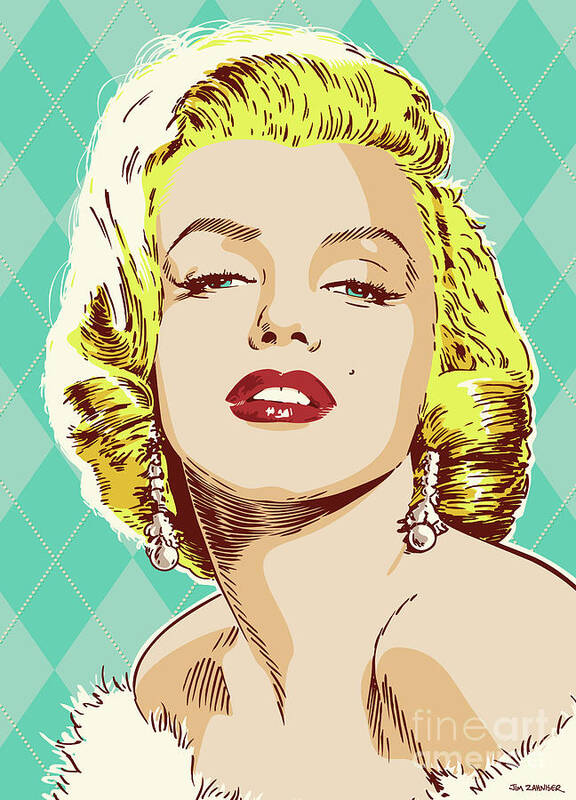

In [18]:
image